In [1]:
import warnings, gc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_curve
from sklearn.preprocessing import LabelEncoder

# h2o modules
import h2o
from h2o.frame import H2OFrame
from h2o.grid.grid_search import H2OGridSearch
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.estimators.random_forest import H2ORandomForestEstimator

# LightGBM modules
import lightgbm as lgb

# CatBoost modules
from catboost import Pool, cv, CatBoostClassifier

warnings.simplefilter('ignore')
pd.options.display.max_rows = 100
%matplotlib inline

# Load Data

In [2]:
train = pd.read_csv('./data/train_clean.csv')
test = pd.read_csv('./data/test_clean.csv')

# imbalanced dataset
target1 = train['target'].sum()
target0 = (1 - train['target']).sum()

print('Train:\t', train.shape)
print('Test:\t', test.shape, '\n')

print('Target 0:\t', target0, '\t', np.round(target0 / len(train), 4))
print('Target 1:\t', target1, '\t', np.round(target1 / len(train), 4))
print('0/1 Ratio:\t', np.round(target0 / target1, 4))

Train:	 (722142, 67)
Test:	 (98727, 67) 

Target 0:	 549951 	 0.7616
Target 1:	 172191 	 0.2384
0/1 Ratio:	 3.1938


In [3]:
# define categorical and numerical features
cat_features = ['term', 'home_ownership', 'verification_status', 'purpose', 
                'title', 'addr_state', 'initial_list_status', 'application_type']

num_features = ['grade', 'sub_grade', 'loan_amnt', 'loan_to_inc', 'int_rate', 
                'installment_ratio', 'emp_length', 'annual_inc', 'dti', 'delinq_2yrs', 
                'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 
                'total_acc', 'collections_12_mths_ex_med', 'acc_now_delinq', 
                'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'acc_open_past_24mths', 
                'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths',
                'delinq_amnt', 'mo_sin_old_il_acct','mo_sin_old_rev_tl_op', 
                'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 
                'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 
                'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 
                'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 
                'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 
                'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 
                'pub_rec_bankruptcies', 'tax_liens', 'tot_hi_cred_lim', 'credit_length',
                'total_bal_ex_mort', 'total_bc_limit', 'total_il_high_credit_limit']

features = cat_features + num_features

# define numerical and categorical features
print('Categorical feature:\t', len(cat_features))
print('Numerical feature:\t', len(num_features))
print('Total feature:\t\t', len(features))

Categorical feature:	 8
Numerical feature:	 57
Total feature:		 65


# I. H2O Data Preparation

In [4]:
# Initialize H2O cluster# # Ini 
h2o.init(nthreads=-1, max_mem_size='30G')
h2o.remove_all()

# Transform to H2O Frame, and make sure the target variable is categorical
h2o_train = H2OFrame(train[features + ['target']])
h2o_test = H2OFrame(test[features])

# transform into categorical
h2o_train['target'] = h2o_train['target'].asfactor()

for name in cat_features:
    h2o_train[name] = h2o_train[name].asfactor()
    h2o_test[name] = h2o_test[name].asfactor()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,2 hours 5 mins
H2O cluster timezone:,Etc/UTC
H2O data parsing timezone:,UTC
H2O cluster version:,3.20.0.1
H2O cluster version age:,1 month and 20 days
H2O cluster name:,H2O_from_python_ubuntu_59topr
H2O cluster total nodes:,1
H2O cluster free memory:,28.04 Gb
H2O cluster total cores:,16
H2O cluster allowed cores:,16
H2O cluster status:,"locked, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


# Logistic Regression

In [5]:
# Create GLM model with 5-folder cross-validation
glm = H2OGeneralizedLinearEstimator(family='binomial', early_stopping=True, nfolds=5, 
                                    balance_classes=True, custom_metric_func='auc',
                                    keep_cross_validation_predictions=True, seed=42)

# Train logistic regression model using grid search
hyper_parameters = {'alpha': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 
                    'lambda': [0, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]}

# Grid search
glm_grid = H2OGridSearch(glm, hyper_parameters)
glm_grid.train(x=features, y='target', training_frame=h2o_train)

glm Grid Build progress: |████████████

H2OResponseError: Server error java.lang.IllegalArgumentException:
  Error: Job is missing
  Request: GET /3/Jobs/$03017f00000132d4ffffffff$_a7d12f4b12208dcd837199945e5f4db7


In [49]:
# Get the grid search result, sorted by AUC
glm_models = glm_grid.get_grid(sort_by='auc', decreasing=True)

# Choose the best model
best_glm = glm_grid.models[0]

# Make predictions
glm_test_pred = best_glm.predict(h2o_test).as_data_frame()['p1'].values

glm prediction progress: |████████████████████████████████████████████████| 100%


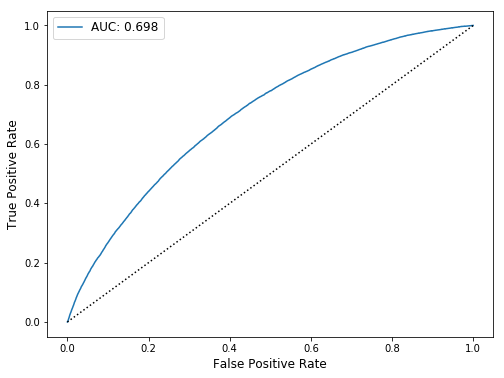

In [50]:
# Build the ROC curve
glm_fpr, glm_tpr, _ = roc_curve(test['target'].values, glm_test_pred)
glm_auc = np.round(auc(glm_fpr, glm_tpr), 3)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(glm_fpr, glm_tpr, label='AUC: ' + str(glm_auc))
ax.plot(glm_fpr, glm_fpr, 'k:')
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.legend(fontsize=12)
plt.show()

# Random Forest

In [ ]:
# random forest grid search
hyper_parameters = {'max_depth': [15, 20, 25, 30, 35], 
                    'mtries': [-1, 8, 15, 20, 25], 
                    'sample_rate': [0.5, 0.632, 0.75]}

# build random forest model
rf_model = H2ORandomForestEstimator(balance_classes=False, ntrees=1000, nfolds=5, 
                                    stopping_rounds=5, stopping_metric='auc', 
                                    keep_cross_validation_predictions=True)

# define search criteria
search_criteria = {'strategy': 'RandomDiscrete', 'max_models': 20, 'seed': 42, 
                   'stopping_metric': 'auc', 'stopping_rounds': 5}

# grid search
rf_grid = H2OGridSearch(rf_model, hyper_parameters, search_criteria=search_criteria)

rf_grid.train(x=features, y='target', training_frame=h2o_train)

drf Grid Build progress: |██

In [ ]:
# get the grid search result, sorted by AUC
rf_sorted_grid = grid_search.get_grid(sort_by='auc',decreasing=True)

In [ ]:
best_max_depth = sorted_grid.sorted_metric_table()['max_depth'][0]
best_mtries = sorted_grid.sorted_metric_table()['mtries'][0]
best_sample_rate = sorted_grid.sorted_metric_table()['sample_rate'][0]
best_ntrees = sorted_grid.sorted_metric_table()['ntrees'][0]
best_auc = sorted_grid.sorted_metric_table()['auc'][0]

In [ ]:
print('Best max_depth:\t', best_max_depth)
print('Best mtries:\t', best_ntrees)
print('Best sample_rate:\t', best_ntrees)
print('Best ntrees:\t', best_ntrees)
print('Best AUC:\t', best_auc)

In [ ]:
# build random forest model with best parameters
h2o_rf = H2ORandomForestEstimator(balance_classes=False, max_depth=, mtries=, 
                                  sample_rate=, ntrees=1000, seed=42)

h2o_rf.train(x=features, y='target', training_frame=h2o_train)

In [ ]:
# Feature importance
importance = rf_model.varimp(use_pandas=True)

fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(x='scaled_importance', y='variable', data=importance[:20])
plt.show()

In [ ]:
importance

In [ ]:
# make prediction file
test_id = test['SK_ID_CURR'].values
test_pred = rf_test_pred

rf_csv = pd.DataFrame({'SK_ID_CURR': test_id, 'TARGET': test_pred}, 
                       columns=['SK_ID_CURR', 'TARGET'])
rf_csv.to_csv('./result/all_feature_h2o_random_forest_balanced.csv', index=False)

In [4]:
# # Shutdown h2o instance
# h2o.cluster().shutdown()

# II. LightGBM Data Preparation

In [ ]:
# encoding categorical data into numerical format
label_encoders = []
for name in cat_feature:
    encoder = LabelEncoder()
    train[name] = encoder.fit_transform(train[name])
    test[name] = encoder.transform(test[name])
    label_encoders.append(encoder)

In [ ]:
# create LightGBM dataset
train_x = train[features]
train_y = train['TARGET'].values

gbm_train = lgb.Dataset(data=train_x, label=train_y, feature_name=features, 
                        categorical_feature=cat_feature, free_raw_data=False)

# Random Forest

In [ ]:
# define parameter space to explore
rf_max_bin_list = [255, 300]
rf_num_leaves_list = [20, 30, 40, 50, 60]
rf_max_depth_list = [-1, 20, 30, 40, 50]
rf_min_data_in_leaf_list = [20, 30, 40, 50]
rf_bagging_frac_list = [0.5, 0.632, 0.7, 0.8]
rf_feature_frac_list = [0.4, 0.5, 0.6, 0.7, 0.8]

rf_max_bin_vals = []
rf_num_leaves_vals = []
rf_max_depth_vals = []
rf_min_data_vals = []
rf_bagging_frac_vals = []
rf_feature_frac_vals = []

rf_mean_auc = []
rf_std_auc = []

In [ ]:
# Random search with Cross validation
s = '|{0:>7s} |{1:>10s} |{2:>10s} |{3:>16s} |{4:>16s} |{5:>16s} |{6:>6s} |{7:>6s} |'
print(s.format('max_bin', 'num_leaves', 'max_depth', 'min_data_in_leaf', 
               'bagging_fraction', 'feature_fraction', 'AUC', 'std'))
print('-' * 104)

# perform random search for given number n
n = 30
np.random.seed(42)
visited = set()
for i in range(n):
    while True:
        max_bin = np.random.choice(rf_max_bin_list)
        num_leaves = np.random.choice(rf_num_leaves_list)
        max_depth = np.random.choice(rf_max_depth_list)
        min_data_in_leaf = np.random.choice(rf_min_data_in_leaf_list)
        bagging_fraction = np.random.choice(rf_bagging_frac_list)
        feature_fraction = np.random.choice(rf_feature_frac_list)
        
        tuples = (max_bin, num_leaves, max_depth, min_data_in_leaf, 
                  bagging_fraction, feature_fraction)
        if tuples not in visited:
            visited.add(tuples)
            break
            
    params = {'objective': 'binary', 
              'boosting': 'rf', 
              'num_threads': 4, 
              'is_unbalance': True, 
              'metric': ['auc'],
              'learning_rate': 0.1, 
              'max_bin': max_bin, 
              'num_leaves': num_leaves, 
              'max_depth': max_depth, 
              'min_data_in_leaf': min_data_in_leaf, 
              'bagging_fraction': bagging_fraction, 
              'feature_fraction': feature_fraction, 
              'bagging_freq': 1, 
              'lambda_l1': 0.0,
              'lambda_l2': 0.0,
              'drop_rate': 0.1}

    # 5-folder cross validation (no early stopping)
    history = lgb.cv(params, train_set=gbm_train, nfold=5, num_boost_round=500, 
                     stratified=True, early_stopping_rounds=None, verbose_eval=False, 
                     seed=42, feature_name=features, categorical_feature=cat_feature)

    # get result
    rf_max_bin_vals.append(max_bin)
    rf_num_leaves_vals.append(num_leaves)
    rf_max_depth_vals.append(max_depth)
    rf_min_data_vals.append(min_data_in_leaf)
    rf_bagging_frac_vals.append(bagging_fraction)
    rf_feature_frac_vals.append(feature_fraction)
    rf_mean_auc.append(history['auc-mean'][-1])
    rf_std_auc.append(history['auc-stdv'][-1])
        
    # output the resuts
    ss = '|{0:7d} |{1:10d} |{2:10d} |{3:16d} |{4:16.4f} |{5:16.4f} |{6:6.4f} |{7:6.4f} |'
    print(ss.format(max_bin, num_leaves, max_depth, min_data_in_leaf, bagging_fraction, 
                    feature_fraction, history['auc-mean'][-1], history['auc-stdv'][-1]))
    
# get the best parameters
idx = np.argmax(rf_mean_auc)
print('-' * 104)
print(ss.format(rf_max_bin_vals[idx], rf_num_leaves_vals[idx], rf_max_depth_vals[idx], 
                rf_min_data_vals[idx], rf_bagging_frac_vals[idx], rf_feature_frac_vals[idx], 
                rf_mean_auc[idx], rf_std_auc[idx]))

In [ ]:
# define best parameters
params = {'objective': 'binary', 
          'boosting': 'rf', 
          'num_threads': 4, 
          'is_unbalance': True, 
          'metric': ['auc'],
          'learning_rate': 0.1, 
          'max_bin': 255, 
          'num_leaves': 60, 
          'max_depth': -1, 
          'min_data_in_leaf': 30, 
          'bagging_fraction': 0.7, 
          'feature_fraction': 0.4, 
          'bagging_freq': 1, 
          'lambda_l1': 0.0,
          'lambda_l2': 0.0,
          'drop_rate': 0.1}

# re-train the model and make predictions
rf = lgb.train(params, train_set=gbm_train, num_boost_round=1000, 
               feature_name=features, categorical_feature=cat_feature)
rf_test_pred = rf.predict(test[features])

# feature importance
importance = rf.feature_importance()

fig, ax = plt.subplots(figsize=(10, 8))
lgb.plot_importance(rf, ax=ax, height=0.5, max_num_features=20)
plt.show()

In [ ]:
# get feature importance details
rf_importance = pd.DataFrame({'feature': features, 'importance': importance}, 
                             columns=['feature', 'importance'])
rf_importance = rf_importance.sort_values(by='importance', ascending=False)
rf_importance

In [ ]:
# make prediction files
test_id = test['SK_ID_CURR'].values
test_pred = rf_test_pred

rf_csv = pd.DataFrame({'SK_ID_CURR': test_id, 'TARGET': test_pred}, 
                       columns=['SK_ID_CURR', 'TARGET'])
rf_csv.to_csv('./result/all_feature_lightGBM_random_forest_balanced.csv', index=False)

# Boosting

In [ ]:
# define parameter space to explore
gbm_learning_rate_list = [0.001, 0.01, 0.1]
gbm_max_bin_list = [255, 400]
gbm_num_leaves_list = [20, 30, 40, 50, 60]
gbm_max_depth_list = [-1, 20, 30, 40, 50]
gbm_min_data_in_leaf_list = [20, 30, 40, 50]

gbm_learning_rate_vals = []
gbm_max_bin_vals = []
gbm_num_leaves_vals = []
gbm_max_depth_vals = []
gbm_min_data_vals = []

gbm_best_rounds = []
gbm_mean_auc = []
gbm_std_auc = []

In [ ]:
# Random search with Cross validation
s = '|{0:>13s} |{1:>7s} |{2:>10s} |{3:>10s} |{4:>16s} | {5:>12s}| {6:>6s} |{7:>6s} |'
print(s.format('learning_rate', 'max_bin', 'num_leaves', 'max_depth', 
               'min_data_in_leaf', 'best_rounds', 'AUC', 'std'))
print('-' * 98)

# perform random search for given number n
n = 30
np.random.seed(42)
visited = set()
for i in range(n):
    while True:
        learning_rate = np.random.choice(gbm_learning_rate_list)
        max_bin = np.random.choice(gbm_max_bin_list)
        num_leaves = np.random.choice(gbm_num_leaves_list)
        max_depth = np.random.choice(gbm_max_depth_list)
        min_data_in_leaf = np.random.choice(gbm_min_data_in_leaf_list)
        
        tuples = (learning_rate, max_bin, num_leaves, max_depth, min_data_in_leaf)
        if tuples not in visited:
            visited.add(tuples)
            break
            
    params = {'objective': 'binary', 
              'boosting': 'gbdt', 
              'num_threads': 4, 
              'is_unbalance': True, 
              'metric': ['auc'],
              'learning_rate': learning_rate, 
              'max_bin': max_bin, 
              'num_leaves': num_leaves, 
              'max_depth': max_depth, 
              'min_data_in_leaf': min_data_in_leaf, 
              'bagging_fraction': 1.0, 
              'feature_fraction': 1.0, 
              'bagging_freq': 0, 
              'lambda_l1': 0.0,
              'lambda_l2': 0.0,
              'drop_rate': 0.1}

    # 5-folder cross validation (no early stopping)
    history = lgb.cv(params, train_set=gbm_train, nfold=5, num_boost_round=1000, 
                     stratified=True,  early_stopping_rounds=30, verbose_eval=False, 
                     seed=42, feature_name=features, categorical_feature=cat_feature)

    # get result
    gbm_learning_rate_vals.append(learning_rate)
    gbm_max_bin_vals.append(max_bin)
    gbm_num_leaves_vals.append(num_leaves)
    gbm_max_depth_vals.append(max_depth)
    gbm_min_data_vals.append(min_data_in_leaf)
    gbm_best_rounds.append(len(history['auc-mean']))
    gbm_mean_auc.append(history['auc-mean'][-1])
    gbm_std_auc.append(history['auc-stdv'][-1])
        
    # output the resuts
    ss = '|{0:>13.5f} |{1:>7d} |{2:>10d} |{3:>10d} |{4:>16d} | {5:>12d}| {6:>6.4f} |{7:>6.4f} |'
    print(ss.format(learning_rate, max_bin, num_leaves, max_depth, min_data_in_leaf, 
                    len(history['auc-mean']), history['auc-mean'][-1], history['auc-stdv'][-1]))
    
# get the best parameters
idx = np.argmax(gbm_mean_auc)
print('-' * 104)
print(ss.format(gbm_learning_rate_vals[idx], gbm_max_bin_vals[idx], gbm_num_leaves_vals[idx], 
                gbm_max_depth_vals[idx], gbm_min_data_vals[idx], gbm_best_rounds[idx], 
                gbm_mean_auc[idx], gbm_std_auc[idx]))

In [ ]:
# define best parameters
params = {'objective': 'binary', 
          'boosting': 'gbdt', 
          'num_threads': 4, 
          'is_unbalance': True, 
          'metric': ['auc'],
          'learning_rate': 0.1, 
          'max_bin': 255, 
          'num_leaves': 50, 
          'max_depth': -1, 
          'min_data_in_leaf': 40, 
          'bagging_fraction': 1.0, 
          'feature_fraction': 1.0,
          'bagging_freq': 0,
          'lambda_l1': 0.0,
          'lambda_l2': 0.0,
          'drop_rate': 0.1}

# re-train the model and make predictions
gbm = lgb.train(params, train_set=gbm_train, num_boost_round=997, 
                feature_name=features, categorical_feature=cat_feature)
gbm_test_pred = gbm.predict(test[features])

# feature importance
importance = gbm.feature_importance()

fig, ax = plt.subplots(figsize=(10, 8))
lgb.plot_importance(gbm, ax=ax, height=0.5, max_num_features=20)
plt.show()

In [ ]:
# get feature importance details
gbm_importance = pd.DataFrame({'feature': features, 'importance': importance}, 
                             columns=['feature', 'importance'])
gbm_importance = gbm_importance.sort_values(by='importance', ascending=False)
gbm_importance

In [ ]:
# make prediction files
test_id = test['SK_ID_CURR'].values
test_pred = gbm_test_pred

gbm_csv = pd.DataFrame({'SK_ID_CURR': test_id, 'TARGET': test_pred}, 
                       columns=['SK_ID_CURR', 'TARGET'])
gbm_csv.to_csv('./result/all_feature_lightGBM_boosting_balanced.csv', index=False)

# III. CatBoost Data Preparation

In [ ]:
# create Pool object
train_pool = Pool(data=train[features], label=train['TARGET'].values, 
                  feature_names=features, cat_features=np.array(range(len(cat_feature))))

test_pool = Pool(data=test[features], feature_names=features, 
                 cat_features=np.array(range(len(cat_feature))))

In [ ]:
train_labels = train['TARGET'].values
print('Negative class:\t', sum(train_labels == 0))
print('Positive class:\t', sum(train_labels == 1))
print('Neg / Pos:\t', sum(train_labels == 0) / sum(train_labels == 1))

# Boosting

In [ ]:
# define parameter space to explore
learning_rate_list = [0.03, 0.05, 0.08, 0.1]
depth_list = [4, 5, 6, 7, 8, 9, 10]
l2_leaf_reg_list = [1, 3, 5, 7, 9]
random_strength_list = [0.1, 0.5, 1, 2]
bagging_temperature_list = [0, 0.2, 0.4, 0.6, 0.8, 1.0]

learning_rate_values = []
depth_values = []
l2_leaf_reg_values = []
random_strength_values = []
bagging_temperature_values = []

best_iterations_values = []
train_mean_auc_values = []
train_auc_std_values = []
test_mean_auc_values = []
test_auc_std_values = []

In [ ]:
# Random search with Cross validation
s = '|{0:>13s} |{1:>5s} |{2:>11s} |{3:>15s} |{4:>19s} |{5:>10s} |{6:>9s} |{7:>9s} |'
print(s.format('learning_rate', 'depth', 'l2_leaf_reg', 'random_strength', 
               'bagging_temperature', 'iterations', 'train_AUC', 'test_AUC'))
print('-' * 108)

# perform random search for given number n
n = 30
np.random.seed(42)
visited = set()
for i in range(n):
    while True:
        learning_rate = np.random.choice(learning_rate_list)
        depth = np.random.choice(depth_list)
        l2_leaf_reg = np.random.choice(l2_leaf_reg_list)
        random_strength = np.random.choice(random_strength_list)
        bagging_temperature = np.random.choice(bagging_temperature_list)
        
        tuples = (learning_rate, depth, l2_leaf_reg, random_strength, bagging_temperature)
        if tuples not in visited:
            visited.add(tuples)
            break
            
    # define parameters
    params = {'loss_function': 'Logloss', 
              'custom_metric': 'AUC', 
              'eval_metric': 'AUC',
              'learning_rate': learning_rate, 
              'depth': depth, 
              'l2_leaf_reg': l2_leaf_reg,
              'random_strength': random_strength, 
              'bagging_temperature': bagging_temperature, 
              'random_seed': 42, 
              'bootstrap_type': 'Bayesian', 
              'has_time': False, 
              'class_weights': [1, 11]}

    scores = cv(pool=train_pool, params=params, iterations=1000, fold_count=5,
                seed=42, shuffle=True, logging_level='Silent', stratified=True,
                as_pandas=False, metric_period=1, early_stopping_rounds=10)
    
    # get result
    learning_rate_values.append(learning_rate)
    depth_values.append(depth)
    l2_leaf_reg_values.append(l2_leaf_reg)
    random_strength_values.append(random_strength)
    bagging_temperature_values.append(bagging_temperature)
    
    best_idx = np.argmax(scores['test-AUC-mean'])
    best_iterations = best_idx + 1
    train_mean_auc = scores['train-AUC-mean'][best_idx]
    train_auc_std = scores['train-AUC-std'][best_idx]
    test_mean_auc = scores['test-AUC-mean'][best_idx]
    test_auc_std = scores['test-AUC-std'][best_idx]
    
    best_iterations_values.append(best_iterations)
    train_mean_auc_values.append(train_mean_auc)
    train_auc_std_values.append(train_auc_std)
    test_mean_auc_values.append(test_mean_auc)
    test_auc_std_values.append(test_auc_std)
    
    # output the resuts
    ss = '|{0:>13.4f} |{1:>5d} |{2:>11d} |{3:>15.4f} |{4:>19.4f} |{5:>10d} |{6:>9.4f} |{7:>9.4f} |'
    print(ss.format(learning_rate, depth, l2_leaf_reg, random_strength, bagging_temperature, 
                    best_iterations, train_mean_auc, test_mean_auc))
    
# get the best parameters
idx = np.argmax(test_mean_auc_values)
print('-' * 108)
print(ss.format(learning_rate_values[idx], depth_values[idx], l2_leaf_reg_values[idx], 
                random_strength_values[idx], bagging_temperature_values[idx], 
                best_iterations_values[idx], train_mean_auc_values[idx], 
                test_mean_auc_values[idx]))

In [ ]:
# build CatBoost classifier
model = CatBoostClassifier(loss_function='Logloss', custom_metric='AUC', eval_metric='AUC',
                           learning_rate=0.05, depth=5, l2_leaf_reg=7, random_strength=0.5, 
                           bagging_temperature=1.0, iterations=869, random_seed=42, 
                           class_weights=[1, 11], bootstrap_type='Bayesian', subsample=None,
                           use_best_model=None, ignored_features=None, one_hot_max_size=None, 
                           has_time=False, rsm=None, nan_mode=None, leaf_estimation_iterations=None, 
                           leaf_estimation_method=None, boosting_type=None, allow_const_label=None)

model.fit(X=train_pool, eval_set=None, logging_level='Verbose', plot=False, 
          column_description=None, metric_period=50, early_stopping_rounds=None)

catboost_test_pred = model.predict_proba(data=test_pool)[:, 1]

In [ ]:
# make prediction files
test_id = test['SK_ID_CURR'].values
test_pred = catboost_test_pred

catboost_csv = pd.DataFrame({'SK_ID_CURR': test_id, 'TARGET': test_pred}, 
                            columns=['SK_ID_CURR', 'TARGET'])
catboost_csv.to_csv('./result/all_feature_boosting_catboost_balanced.csv', index=False)